# Estimate parameters of the model in 5_Miyazaki

### pre-setting

In [1]:
%load_ext Cython
import scipy.stats as stats 
from scipy.stats import norm
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd 
import numpy as np
import re 
import os


import time 
from datetime import datetime


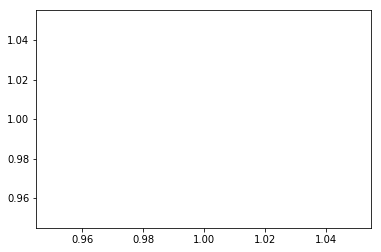

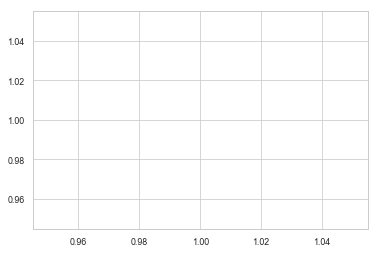

In [2]:
plt.plot(1,1)
plt.show()
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})
plt.plot(1,1)

# Implementation part  

In [3]:
t = np.linspace(0,20,200)
tau = t[1] - t[0]
def pr_all(mu=5,sigma =2,bins = 200,beta = 50,PReward =0.25 ):
    nm = norm(loc = mu,scale = sigma)
    y = nm.pdf(t)
    yy = 1 - nm.cdf(t)
    # probability of quitting 
    PPosterior = PReward*yy/( PReward*yy + 1-PReward  )
    PWait =   1 / (1 + np.exp(-beta*PPosterior))
    Pwaitings = [1]
    Pquit = []
    for pw in PWait:
        Pquit.append(Pwaitings[-1]*(1-pw))
        Pwaitings.append(Pwaitings[-1]*pw)
    total = np.sum(Pquit)
    plt.plot(t,Pquit/total,label=str(PReward))
    print(tau)
    print(np.sum(Pquit)*tau)

0.10050251256281408
0.10050251256281408


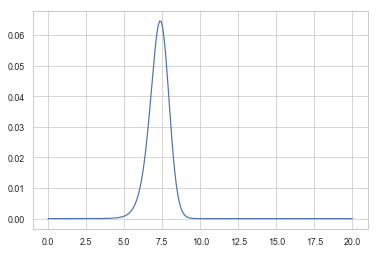

In [4]:
pr_all()

##  mcmc implementation part 


In [24]:
%%cython -a

from datetime import datetime

import numpy as np
cimport numpy as np
cimport cython
from libc.stdlib cimport rand, RAND_MAX
from scipy.stats import norm

cdef extern from "time.h":
    ctypedef unsigned long clock_t
    cdef clock_t clock()
    cdef enum:
        CLOCKS_PER_SEC

ctypedef np.double_t DTYPE_t 

################### basic mathematical function ################ 

DEF  PI = 3.141592653589793


cdef extern from "math.h":
    double sqrt(double x)
    double sin(double x)
    double cos(double x)
    double exp(double x)
    double log(double x)
    double INFINITY
    double acos(double x)
    double pow(double x, double y)
    int round(double x)
    double fabs(double x)
    double fmod(double x, double y)
    double floor(double x)
    
    

################### distributions ################ 
'''
    uniform , 
    normal , 
        are supported here 

'''

###### uniform distribution
@cython.cdivision(True)
cdef double uniformRand():
    cdef double r = rand()
    #print(r)
    return( r/  RAND_MAX)

##### normal distribution 
cdef double normRand(double mu = 0 , double sd = 1):
    cdef double u1, u2, z

    u1 = uniformRand()
    u2 = uniformRand()
    z = sqrt(-2*log(u1))*cos(2*PI*u2)

    return (z*sd + mu)

@cython.cdivision(True)
cdef double normPdf(double x,double mu = 0,double sd = 1 ):
    return( 1/( sd*sqrt(2*PI)) *exp(-1/2*pow( (x - mu)/sd,2) )  )


##### gamma function 
cdef double gammaFunc(int n,bint _log = False):
    cdef int i 
    cdef double v
    v = 0
    if n != 0:
        for i in range(1,n):
            v += log(i)
    else:
        v = 1
        
    if _log:
        return(v)
    else:
        return( exp(v) )


'''
####################   MCMC implementation    ##########################
Change following parts of the code 
- const int : N_PAR : number of parameters 
- const int :  DATA_SIZE : if you have large number of data, change this 
- func : __init__ in likelihood : initial value for MCMC 
- func : setData : edit as appropriate for l_lklh 
- func : setParameter : edit as appropriate for l_lklh 
- func : l_lklh : log_likelihood function, this maximizes this return value
(- func : __init__ in MCMC : set some parameters for MCMC setting )
'''

DEF  N_PAR = 4
DEF  DATA_SIZE = 10000
DEF  N_TIME = 200
DEF  BINS_C_NORM = 5000

cdef int searchInd(double v,int l_,int h_,double *x,double tau):
    cdef int m_

    m_ = round((l_ + h_ )/2 )
    if x[m_] - tau <= v and v <= x[m_] + tau :
        return(m_)
    if v < x[m_]:
        h_ = m_ 
        return(searchInd(v,l_,h_,x,tau))
    else:
        l_ = m_
        return(searchInd(v,l_,h_,x,tau))

cdef class likelihood:
    '''
    Likelihood function is defined here 
    '''


    cdef public parName 
    cdef public double mu 
    cdef public double sigma
    cdef public double PReward
    cdef public double beta 
    
    def __init__(self):
        ##### initialize parameters for the model 
        self.mu = 5
        self.sigma = 2
        self.PReward = 0.2
        self.beta = 100
        self.parName = ["mu","sigma","PReward","beta"]
        
    
    cdef public int n
    cdef public double y[DATA_SIZE]
    cdef public int d[DATA_SIZE]
    cdef public double t[N_TIME]
    cdef public double values[BINS_C_NORM]
    cdef public double x[BINS_C_NORM]
    cdef public double tau
    def setData(self,data):
        # if more data 
        t,d_ = data 
        self.n = len(d_)
        
        if self.n > DATA_SIZE:
            raise Exception("# of data is," + str(self.n) + ", change value of DATA_SIZE(" 
                            + str(DATA_SIZE) + ")")
        for i in range(self.n):
            self.d[i] = d_[i]
        for i in range(N_TIME):
            self.t[i] = t[i] 
            
        # for cumulative desity function of normal distribution 
        x = np.linspace(-5,5,BINS_C_NORM)
        self.tau = (x[1]-x[0])/2
        nm = norm(loc = 0,scale = 1)
        for i in range(BINS_C_NORM):
            self.x[i] = x[i]
            self.values[i] = nm.cdf(x[i])

    cdef int setParameters(self,double *par):
        self.mu = par[0]
        self.sigma = par[1]
        self.PReward = par[2]
        self.beta = par[3]
        

    cdef double normCumulative(self,double v):
        cdef int ind 
        if v < self.x[3]:
            return(self.values[3])
        elif v > self.x[BINS_C_NORM -3 ]:
            return(self.values[BINS_C_NORM - 3])
        ind = searchInd(v,0,BINS_C_NORM,self.x,self.tau)
        return(self.values[ind])
    
        
    @cython.cdivision(True)
    cdef double l_lklh(self):
        cdef int i 
        cdef double normT
        cdef double l 
        cdef double Pquit[N_TIME]
        cdef double Pwaiting[N_TIME]
        cdef double PPosterior[N_TIME]
        cdef double PReward[N_TIME]
        cdef double PWait[N_TIME]
        cdef double yy[N_TIME]
        

        # calculate distribution for calculation 
        Pquit[0] = 0
        Pwaiting[0] = 1
        
        
        for i in range(1,N_TIME):
            normT = (self.t[i] - self.mu )/self.sigma
            yy[i] = 1 - self.normCumulative(normT)
            # probability of quitting 
            if yy[i] != yy[i]:
                return(-1000000)
            PPosterior[i] = self.PReward*yy[i]/( self.PReward*yy[i] + 1-self.PReward  )
            PWait[i] =   1 / (1 + exp(-self.beta*PPosterior[i]) )
            
            Pquit[i] = Pwaiting[i-1]*(1-PWait[i])
            Pwaiting[i] = Pwaiting[i-1]*PWait[i]
        
        # use this distribution and calculate likelihood 
        
        l = 0
        for i in range(self.n):

            l +=  log(Pquit[self.d[i]])
        return(l)
'''
-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------
'''

cdef class MCMC(likelihood):
    '''
    MCMC common part 
    '''
    cdef public int nSim
    cdef public double nThin
    cdef public str path2save
    cdef public int sampleN
    cdef public double preTime
    cdef public double logLikelihood
    
    cdef public double acceptanceTimes[N_PAR]
    cdef public double probabilityAccept[N_PAR]
    cdef public t_ 
    cdef public s
    cdef public double sdRandomWalk[N_PAR]
    
    def  __init__(self,path = "result.txt"):
        super().__init__()
        '''
        Default parameters for MCMC 
        '''
        self.nSim = 50000
        self.nThin = 100 
        self.path2save = path 
        self.sampleN= 0
        self.preTime = 0
        
        cdef int i             
        sd = [1,0.2,1,1]
        for i in range(N_PAR):
            self.sdRandomWalk[i] = sd[i]
            
        # for initialization 
        for i in range(N_PAR):
            self.acceptanceTimes[i] = 0
    
    def printCondition(self):
        self.s = ""
        self.s = "########## MCMC Condition  #############" + "\n"
        self.s += "# file_path : " + self.path2save + "\n"
        self.s += "# parameters : " + ", ".join(self.parName) + "\n"
        self.s += "# setting,{ 'nSim' : %d , 'nThin' : %d}\n"  % (self.nSim,int(self.nThin))
        self.s += "#\n"
        self.s += "########### MCMC Chain #############" + "\n"
        self.s += "sample,loglikelihood," + ",".join(self.parName) + ",time (sec/M)" + "\n"
        
        print(self.s)
        
    def recordCondition(self,f):
        f.write(self.s)
        
    cdef recordParameters(self,f,double *par_a):
        runTimeM = (clock() - self.preTime) /CLOCKS_PER_SEC /self.nThin*1000000
        self.preTime = clock()
        
        self.s = ""
        self.s += str(self.sampleN) + "," + str(self.logLikelihood)
        for i in range(N_PAR):
            self.s += "," + str(par_a[i])
        self.s += "," + str(runTimeM)
        self.s += "\n"
        
        f.write(self.s)
        
    cdef printParameters(self,par_a):
        print(self.s)
        
    cpdef double probabilityOfAcceptance(self,f = None,save=True):
        cdef int i 
        
        self.s = "#\n#\n"
        self.s += "######  Probability of acceptance for each parameter ######\n"
        self.s += "# parameter name  : sd for random walk :# of acceptance : prob. of acceptance \n"
        for i in range(N_PAR):
            self.probabilityAccept[i] =  self.acceptanceTimes[i]/self.sampleN
            self.s += "# " + self.parName[i] + " : " \
                + str(self.sdRandomWalk[i]) + " : " + str(self.acceptanceTimes[i]) + " : "\
                + str(self.probabilityAccept[i])  + "\n"
        print(self.s)
        if save:
            f.write(self.s)
        
        
    cdef double parameterRenewal(self,double *par_a,double *par_c ,int index ):
        cdef int i 
        cdef double acc, v_c,v_a 
        for i in range(N_PAR):
            par_c[i] = par_a[i]
        
        par_c[index] = par_c[index] + normRand(mu = 0,sd = self.sdRandomWalk[index])
        self.setParameters(par_a)
        v_a = self.l_lklh()
        self.setParameters(par_c)
        if index == 2 and (par_c[index] > 1 or par_c[index] < 0):
            v_c = -1000000       
        elif index == 1 and par_c[index] < 0:
            v_c = -1000000       
        elif index == 0 and par_c[index] < 0:
            v_c = -1000000
        elif index == 4 and par_c[index] < 0:
            v_c = -1000000
        else:
            v_c = self.l_lklh()
        
        acc = exp(v_c - v_a )

        u = uniformRand()
        if acc > u:
            par_a[index] = par_c[index]
            self.logLikelihood = v_c
            self.acceptanceTimes[index] += 1 
        else:
            self.logLikelihood = v_a
    
    def run(self):
        '''
        MCMC chain part 
        '''
        cdef int i 
        cdef int index
        cdef double par_a[N_PAR]
        cdef double par_c[N_PAR]
        
        self.t_ = datetime.now().strftime("%y%m%d_%H%M%S")
        self.path2save = self.t_ + ".txt"
        with open(self.path2save  ,mode = "w") as f:
            self.printCondition()
            self.recordCondition(f)
            
            
            for i in range(self.nSim):
                for index in range(N_PAR):
                    self.parameterRenewal(par_a,par_c,index)
            
                self.sampleN += 1                            
                if self.sampleN % self.nThin == 0:
                    if i == 0:
                        continue
                    self.recordParameters(f,par_a)
                    self.printParameters(par_a)
            
            self.probabilityOfAcceptance(f)
    

In [25]:
## data setting part 
N_TIME = 200
tQuit = [5.25]*3 + [5.75]*9 + [6.25]*22 + [6.75]*39 + [7.25]*47 + [7.75]*52 + [8.25]*32 \
    + [8.75]*30 + [9.25]*16 + [9.75]*7 + [10.25]*6 + [10.75]*6 + [11.25]*5 + [12.25]*5 + [12.75]*3 + [13.75]
t = np.linspace(0,20,N_TIME)
tau = t[1] - t[0]
d = []
tQuit = np.sort(tQuit)
ind = 0 
for i, tt in enumerate(t):
    flag =  tt - tau/2 < tQuit[ind] and tQuit[ind] < tt + tau/2
    while flag:
        d.append(i)
        if ind + 1 == len(tQuit):
            break
        ind += 1
        flag =  tt - tau/2 < tQuit[ind] and tQuit[ind] < tt + tau/2


In [26]:
mcmc =MCMC()
mcmc.setData([t,d])
mcmc.nSim = 1000000
mcmc.nThin = 1000
mcmc.sdRandomWalk = [2,2,0.5,10]

In [27]:
mcmc.run()

########## MCMC Condition  #############
# file_path : 190528_001911.txt
# parameters : mu, sigma, PReward, beta
# setting,{ 'nSim' : 1000000 , 'nThin' : 1000}
#
########### MCMC Chain #############
sample,loglikelihood,mu,sigma,PReward,beta,time (sec/M)

1000,-1199.1311427019184,1.270154078666307,6.741790564054831,0.4158747843721142,30.08914861391592,50359.985

2000,-1196.0645755257162,0.03126294199513424,6.881043525899668,0.427783971218561,35.03447170801035,207.679

3000,-1194.8891954274898,0.05481556825284486,6.953391183749404,0.39910941654319015,38.01370603001179,209.266

4000,-1197.8945698745545,0.6524337552743353,6.379748908839831,0.3854691973385565,39.6637872800049,207.049

5000,-1195.0864081312761,0.3645587696156858,6.9114733682365745,0.3850677952617156,38.447348275890334,210.63899999999998

6000,-1195.6786846790014,0.2598748730984034,7.119332037668046,0.39424099070472374,36.744788087587516,215.993

7000,-1197.7327352718935,0.5234633348222041,7.395126596802039,0.352545651652161


78000,-1192.0239567911378,0.2575453832225646,7.514236503074159,0.09953450627381465,179.12728850296048,208.247

79000,-1192.6931891202255,0.4182469840491519,7.186381005035875,0.10813417441439885,177.40816548900185,204.62900000000002

80000,-1192.784909252882,0.36613216131091225,7.0824008517813875,0.11540657048727694,168.80382182283583,206.63000000000002

81000,-1192.165464302669,0.41907811691302777,7.577747617666938,0.11140827504644353,157.1178479019019,214.071

82000,-1191.6342930883088,0.6704354229043544,6.793890064861406,0.10675945231329984,178.74089227143963,209.547

83000,-1192.0580454033532,1.1586355713857428,6.968220079356065,0.1054620371776795,157.96063072630358,206.596

84000,-1192.9456005611703,0.8817425106805115,6.702129202092057,0.09618274157512105,191.4179657539071,214.931

85000,-1191.2639453631905,0.3080668771077424,7.02092406730073,0.09025057710252228,221.38048105920498,218.159

86000,-1192.2522685853048,0.568790516131255,7.56938674498145,0.08782848627424046,194.6593231


153000,-1193.9355585925225,1.5752760905229528,6.6213783586338995,0.05604624914836239,311.25419104777853,220.872

154000,-1191.1121296987449,0.5534933662078703,7.106505861033828,0.05762516125283571,337.05879886716616,213.82000000000002

155000,-1191.4961277728212,0.1353063144074891,7.807112082954481,0.06304739262493445,289.30982943327183,214.87

156000,-1192.9837769502521,1.2315748878644528,6.954808482284985,0.06090783953082443,274.9039999194898,211.70600000000002

157000,-1195.4345242643246,0.38139623554624713,6.801299866617529,0.057541711472470315,380.0332928068979,214.00099999999998

158000,-1192.0041037654482,0.5153270311091868,7.497778591686092,0.057541711472470315,305.4843748502593,210.06799999999998

159000,-1191.7321301581094,0.7959368715709302,7.156456032038013,0.05744006944076634,310.47055079041667,207.05499999999998

160000,-1191.3190773515803,0.31178735311087125,7.562677690545622,0.05574835678525849,327.84081943937605,223.448

161000,-1196.5856992469426,0.6551803406880653,6

226000,-1192.0435452548222,1.1402176749340283,7.0631332992801665,0.09040015909388366,184.91784759407497,200.808

227000,-1191.3299200240187,0.6941223582550986,7.165332963634213,0.08871070565069175,203.141394565455,213.99099999999999

228000,-1191.7588759193034,0.061977963039889644,7.215056589578079,0.08628799856373738,240.5605722641806,212.538

229000,-1191.660849060828,0.3734628803454722,7.198118722103522,0.09516487176725207,194.11831641488266,202.572

230000,-1192.9697652177524,0.05498929890441759,7.989005023316881,0.0915079261866236,191.7024744037908,200.60600000000002

231000,-1190.966393063348,0.6396516275817301,7.279019065070098,0.09202626783751461,192.45731536829084,209.756

232000,-1190.5914236501485,0.17709214987873692,7.196574995583459,0.08715632750175106,228.89445494064904,212.174

233000,-1193.2107493160997,1.4058815734891703,7.028328664877679,0.08415389739735121,194.0119422770044,204.693

234000,-1191.1774739474054,0.15790458138207317,7.226892328455151,0.09514125193350453,

298000,-1191.7917087676526,0.010749478860526391,7.17231848602779,0.09906381256100188,210.4484570781404,203.997

299000,-1192.0960237070797,0.07205384989917413,7.828958135901932,0.0959982428706251,185.24605095668142,200.54

300000,-1191.7475286537983,0.850615185788571,7.114062235911773,0.0947940549173656,182.04134250771833,201.87300000000002

301000,-1190.7928214969372,0.14253670728502632,7.544804548218468,0.09697882871320718,190.06688549799352,199.867

302000,-1193.0653716880927,0.5724833890940471,6.9283417254766135,0.09697882871320718,190.10064327251965,198.412

303000,-1191.2719734866853,0.11186565212517383,7.086564645839378,0.10105096049394403,195.8411536207437,204.787

304000,-1192.3490612932274,0.6679229836346282,6.996629331371365,0.09493533219910111,199.96933556502796,202.871

305000,-1190.939076159626,0.38632968877943574,7.282437159286346,0.09493533219910111,194.05441462586865,199.822

306000,-1192.9383624825125,0.31646330962522357,6.885540673333034,0.08208850470346085,254.73502


372000,-1195.14218591343,1.1344513987401768,7.625809666064589,0.0932024603285902,165.1804167927596,212.704

373000,-1193.2582905061388,1.4327570812346049,6.794311050217159,0.0945453138866857,174.9886764509455,203.585

374000,-1194.513813454699,1.6608962396151665,7.188438467082946,0.09401803993156344,158.50700644698549,210.826

375000,-1191.9996144892277,0.33606501448534243,7.706041487815578,0.09826320966705324,179.32607586969982,201.151

376000,-1192.0142605575588,0.20904313407098546,7.159555417507692,0.10106148133712284,188.2598289383304,201.548

377000,-1192.2579522221267,0.7626273841499659,7.137804918203353,0.10452815255675159,165.00584364338098,202.19000000000003

378000,-1194.1852602702063,0.18069374993856424,6.778860446333118,0.10322835000837174,211.81929286859616,201.377

379000,-1191.213843128813,0.043000701343595876,7.635780075771445,0.09896415193592227,186.00204127150997,200.216

380000,-1191.212001320144,0.03895415625537614,7.15669719720091,0.10603315784265882,191.958302156

444000,-1192.1826359866943,0.4426330450542082,7.08529212451848,0.08731461387710727,224.41954314406334,203.856

445000,-1191.1439760058036,0.43818367819452525,7.175313318566365,0.10384439323915733,179.23255152481985,208.594

446000,-1191.2181187678136,0.47360510214380924,7.170874270425283,0.10470583483883374,176.99751169104286,217.70600000000002

447000,-1191.5295388160705,0.44246931572357207,7.170149304753704,0.10261542139208295,178.0887250991799,218.15599999999998

448000,-1191.0183123924885,0.16173272799054728,7.487955907033989,0.09708197867619177,191.3526605161812,215.95600000000002

449000,-1190.5814168655647,0.1256874237920917,7.3995277421887895,0.09171597020591876,212.3883778330362,198.414

450000,-1191.8961703691327,0.09065253499985977,7.396005836123174,0.09071336785432144,207.4025498183125,199.162

451000,-1191.771340312956,0.052964890445017065,7.625341879029612,0.08708188337318229,212.06912695013864,199.168

452000,-1193.9630991659085,1.1389653294160644,7.2830808774877935,0.08

516000,-1193.8962931722474,0.6147622264650264,7.312941194108408,0.15595065236371433,110.7431645792311,200.438

517000,-1192.9348792541202,0.892968511275628,7.105772646320915,0.16198812807641857,100.52334618937226,202.09699999999998

518000,-1191.8875435854925,0.06111143888680446,7.639108614847688,0.15284571277887068,114.84468664453694,202.23299999999998

519000,-1192.9358837997431,0.2797087390176954,7.108051245352879,0.1350633542091117,143.8718401796488,198.74

520000,-1191.7548675901978,0.09148456138998676,7.46729927067229,0.13838665701648473,129.8139534254843,201.485

521000,-1192.0655780268503,0.03466383687319885,7.689034935585171,0.14745327185166304,120.8129135924036,200.034

522000,-1192.2482888284749,0.550673873735918,7.000488433353137,0.16112855271742355,112.1397958280276,198.352

523000,-1192.7874764257538,0.8739280924380556,6.763791841713331,0.15251420097720436,114.55859680814947,204.00099999999998

524000,-1193.3708000755885,0.714944011347016,7.491756193256903,0.1316738199180

589000,-1193.6331860540276,0.9327023603789854,7.312220479622193,0.16676581297340495,94.14368915355696,200.44500000000002

590000,-1195.992955151952,0.7037703112147535,7.707556448305192,0.17213567752117753,91.61968088491076,201.051

591000,-1190.9558950083508,0.021433709106914008,7.251110130414871,0.15722869063359995,121.05138813496743,200.40699999999998

592000,-1193.5725877885204,0.3325588968260672,7.370199066504185,0.15343910108480888,110.04442504860292,201.92299999999997

593000,-1192.9072041802415,0.3413022191393028,7.242993199512423,0.17150322077849062,105.17289635656525,201.334

594000,-1191.7092448957233,0.23011765174448007,7.041440379457946,0.18614625040622113,98.11383498733983,205.897

595000,-1191.917191200986,0.16963245116133369,7.469968329891364,0.172856586989664,101.5802276973627,203.221

596000,-1193.2302050368091,1.00093991518827,6.843650034955017,0.17057004849711055,98.59683489361481,204.57800000000003

597000,-1193.9813704046921,0.7711710685764576,7.01874738414704,0.17

663000,-1194.0893594983693,0.9654753094340733,6.888583140660587,0.18107887558970165,93.16975860485036,203.44899999999998

664000,-1194.6175054415405,1.0662423752689814,6.562547261660863,0.185870110723985,92.09271755317417,210.688

665000,-1195.1550709624887,1.2711583089986558,6.434782937343252,0.1874662437645385,87.3340936010494,203.77200000000002

666000,-1192.7053984352513,0.2853374356979021,7.0171875515315465,0.2228242880445127,78.60148059430557,208.655

667000,-1192.8513156363297,0.2398320889366887,7.400717843464745,0.22485634616827704,73.67320276625853,205.973

668000,-1191.950691860998,0.017012125665699318,7.159447213616108,0.22468569625520793,80.88652592854554,201.59900000000002

669000,-1194.1290103608242,1.1212723725659286,6.806095282180085,0.22849011828345983,66.6852732067431,210.42700000000002

670000,-1192.3005089502483,0.011776615548526936,7.439444644605689,0.22561516927151115,76.12789864576325,218.15300000000002

671000,-1192.7751914597468,0.1468111734722009,7.29769421739

734000,-1190.966540805988,0.16873112371549406,7.644990602406024,0.05738183091854175,331.60593383161796,200.14000000000001

735000,-1192.1995783468608,0.5680402681882365,7.652593072066929,0.0573332793364757,302.1319273630714,201.14600000000002

736000,-1191.363845552758,0.4079381046985195,6.9473229325743135,0.0573332793364757,349.80638082236925,203.838

737000,-1193.0717890455164,1.2450569302513175,7.163270121453875,0.058099380027464814,293.98728148462106,204.661

738000,-1190.937179846465,0.19649808283591802,7.036074151307119,0.05322903882843292,391.3297898302302,200.321

739000,-1191.7517181366752,0.9764122728555908,7.094458310533779,0.05273265339395322,330.91022563888083,202.231

740000,-1192.0766435697474,1.1609709213805588,7.151023060566186,0.05326827787309599,318.91850098478795,203.15900000000002

741000,-1191.0616193846315,0.20765350732983964,7.071283045881244,0.054662497508176644,378.9024992255931,201.779

742000,-1197.2555337912038,1.8841204958165585,6.388539994249503,0.0560974

808000,-1191.625245969333,0.6281868416217808,7.148442015282824,0.07603405329740673,246.51378540662955,199.769

809000,-1192.7483130224275,0.042695878421154215,6.883424267343135,0.06747272546691589,329.0190964202887,197.79

810000,-1191.6092751804135,0.5873792908806541,7.499656782365235,0.06899568548299294,252.69548211928182,201.655

811000,-1189.9059974481547,0.21044274224737325,7.375711665427683,0.06589909276689224,290.3596098670216,202.863

812000,-1189.3180285500378,0.015164033662444586,7.380535974894495,0.06705492947643057,300.6779663013265,216.13899999999998

813000,-1191.6707102656746,0.43449307999439174,7.356449008803936,0.06329756180422585,286.90841175402164,198.736

814000,-1191.5228695504734,0.6216414989924904,7.306442981458968,0.07037086198724811,259.9925048955998,214.271

815000,-1192.845798521562,0.3806677029050664,6.793137595908835,0.07105846493156598,297.4447111295792,205.74

816000,-1193.0139849234781,0.9514973917851965,6.668569658321099,0.07294345988958896,254.44977443

882000,-1192.2955932446264,0.14768185419183877,7.0775757822079495,0.07254352054992888,274.06634401558625,223.909

883000,-1191.2096588759073,0.7187966915033832,7.171530358323528,0.07254352054992888,249.23509395489629,211.527

884000,-1190.4755733822944,0.11434577856109703,7.522908161006353,0.06912221340190419,274.8580019640546,210.328

885000,-1193.8842967867856,0.8745014592531749,7.42512253253587,0.06659698491578242,263.8987121420523,208.749

886000,-1191.7149255129877,0.12504007630095562,7.015339151012847,0.062240920283693664,345.32275687292,208.84300000000002

887000,-1190.5061157680127,0.08566400181996757,7.322687227647131,0.059375966054527676,344.66228305812587,212.60799999999998

888000,-1193.190201754549,0.21462955307418946,6.734694605917404,0.05953252104835094,371.0574053696297,207.371

889000,-1192.488796537552,0.9473817406001948,6.972658409330806,0.04977049640452269,370.30809317191034,214.792

890000,-1193.2162782634682,0.1565366766073033,7.179668883331704,0.04639570620916333

954000,-1191.80291466982,0.8288504954513457,7.403280615949028,0.04360118089973419,401.45601906785487,215.17

955000,-1192.4135139390753,0.16413533453253668,7.232029635459726,0.039964737742268754,492.6482209016207,216.70200000000003

956000,-1193.1580804175603,1.3404602385045152,6.793942633227826,0.039051613702294895,454.8546058120452,223.74

957000,-1191.6445755938921,0.8089877746039904,7.242545369764945,0.03783975757789418,485.1200962857438,213.166

958000,-1190.8941780307196,0.327324607038602,7.327290142094757,0.04064032527493003,469.5891296983064,211.195

959000,-1190.728558435472,0.03919238571086818,7.065813053291742,0.04064032527493003,536.0096938191845,207.518

960000,-1191.7207610087191,0.44368489087758534,6.850408063633033,0.040762630010193764,512.0513939148233,209.155

961000,-1190.600592287893,0.09896187360181091,7.480791049944906,0.04471405470301099,434.5481806193708,221.992

962000,-1191.7437409584695,0.318338910645488,6.916305379150945,0.04472668338469173,477.1586549621667

In [28]:
mcmc.probabilityOfAcceptance(save=False)
print(mcmc.path2save)

#
#
######  Probability of acceptance for each parameter ######
# parameter name  : sd for random walk :# of acceptance : prob. of acceptance 
# mu : 2.0 : 51953.0 : 0.051953
# sigma : 2.0 : 62075.0 : 0.062075
# PReward : 0.5 : 4345.0 : 0.004345
# beta : 10.0 : 407926.0 : 0.407926

190528_001911.txt
